In [1]:
from typing import List

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
sns.set(style="darkgrid")
sns.set(rc={'figure.figsize':(16,8)})


from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report, roc_curve, auc
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

import utils

# Preprocessing Data

In [12]:
train = pd.read_csv('data/heart_train.csv')
val = pd.read_csv('data/heart_val.csv')
test = pd.read_csv('data/heart_test.csv')

protected = "Race"
target_variable = "HeartDisease"

continuous_features = list(train._get_numeric_data().columns)
categorical_features = list(set(train.columns) - set(continuous_features) - set([target_variable]) - set([protected]))

In [13]:
def mean_of_age_category(row):
    if "older" in row:
        return 80
    else:
        return np.mean(list(map(int, row.split("-"))))


def data_preprocessing(data: pd.DataFrame, categorical_features: List[str], continuous_features: List[str], target_variable: str):

    df = data.copy()
    
    # subset df
    df = df[(df["Race"]=="White") | (df["Race"]=="Black")]
    df["AgeCategory"] = df["AgeCategory"].apply(mean_of_age_category)
    
    # target
    target = df[target_variable].values
    d = {"No":0, "Yes":1}
    target = np.array(list(map(lambda x: d[x], target)))

    # protected variables
    sex = df["Sex"].values
    age = df["AgeCategory"].values
    race = df["Race"].values

    df_processed = df[categorical_features + continuous_features].copy()
    df_processed = pd.get_dummies(df_processed, prefix=None, prefix_sep='_',
                                  dummy_na=False, columns=categorical_features, drop_first=True)

    return df_processed, df, target, sex, age, race


train_processed, train_original, train_target, train_sex, train_age, train_race = data_preprocessing(
    train, categorical_features=categorical_features, continuous_features=continuous_features, target_variable=target_variable)

val_processed, val_original, val_target, val_sex, val_age, val_race = data_preprocessing(
    val, categorical_features=categorical_features, continuous_features=continuous_features, target_variable=target_variable)

test_processed, test_original, test_target, test_sex, test_age, test_race = data_preprocessing(
test, categorical_features=categorical_features, continuous_features=continuous_features, target_variable=target_variable)

In [14]:
train_processed

,BMI,PhysicalHealth,MentalHealth,SleepTime,Sex_Male,Asthma_Yes,Smoking_Yes,PhysicalActivity_Yes,AgeCategory_27.0,AgeCategory_32.0,...,GenHealth_Poor,GenHealth_Very good,AlcoholDrinking_Yes,KidneyDisease_Yes,DiffWalking_Yes,"Diabetic_No, borderline diabetes",Diabetic_Yes,Diabetic_Yes (during pregnancy),SkinCancer_Yes,Stroke_Yes
0,23.44,0.0,1.0,7.0,0,0,1,1,0,0,...,0,0,0,0,0,0,0,0,0,0
1,23.11,0.0,0.0,7.0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,35.51,2.0,1.0,7.0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
3,21.79,0.0,0.0,8.0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,1,0,0
4,47.59,30.0,20.0,6.0,1,0,1,1,0,0,...,1,0,0,0,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
223851,30.81,0.0,0.0,5.0,1,1,1,1,0,0,...,0,0,0,0,0,0,0,0,0,1
223852,31.45,4.0,0.0,10.0,0,0,1,0,0,0,...,0,1,0,1,1,0,1,0,0,0
223853,18.89,0.0,0.0,7.0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
223854,25.02,0.0,0.0,8.0,1,0,0,1,0,0,...,0,0,0,0,0,0,1,0,0,0


# Equalized odds with roc curves

### Model Training

In [4]:
scaler = ColumnTransformer(
    [('scaler', StandardScaler(), continuous_features)], remainder='passthrough')

whitebox_model = Pipeline(steps=[('scaler', scaler), ('clf', DecisionTreeClassifier())])

whitebox_model.fit(train_processed, train_target)

Pipeline(steps=[('scaler',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('scaler', StandardScaler(),
                                                  ['BMI', 'PhysicalHealth',
                                                   'MentalHealth',
                                                   'SleepTime'])])),
                ('clf', DecisionTreeClassifier())])

## Validation & Equalized Odds

In [5]:
def equalized_odds(preds, groups, test):
    df = pd.DataFrame(list(zip(preds, groups, test)), columns=['preds', 'groups', 'test'])
    targets = df['test'].unique()
    groups = df['groups'].unique()
    labels = []
    y = []
    
    for target in targets:
        temp_labels = []
        temp_y = []
        for group in groups:
            selection = df.loc[(df['test'] == target) & (df['groups'] == group)]
            corrects = selection.loc[selection['preds'] == target]
            score = round(len(corrects) / len(selection), 3)
            temp_labels.append(f'T: {target}, G: {group}')
            temp_y.append(score)
        labels.append(temp_labels)
        y.append(temp_y)
    

    
    # PLOTTING
    fig, ax = plt.subplots(figsize=(8,6), sharey=True)
    
    x = np.arange(len(groups))  # the label locations
    x = np.array([i*2 for i in x])
    width = 0.8
    
    rects1 = ax.bar(x - width/2, y[0], width, label='No') #0
    rects2 = ax.bar(x + width/2, y[1], width, label='Yes') #1
    
    # Add some text for labels, title and custom x-axis tick labels, etc.
    ax.set_ylabel('Score')
    ax.set_title('Scores by group and target')
    ax.set_xticks(x, groups, rotation=10)
    ax.legend(bbox_to_anchor=(1.01, 1), loc=2, borderaxespad=0.)
    
    ax.bar_label(rects1, padding=3)
    ax.bar_label(rects2, padding=3)

    plt.tight_layout()
    plt.show()

In [6]:
def plot_roc_curve(y_race:np.ndarray, y_target:np.ndarray, y_pred_proba:np.ndarray):
    fix, ax = plt.subplots(figsize=(6,6))
    parameters = {"fpr": [], "tpr": [], "threshold": []}

    for race in np.unique(y_race):
        y_score = y_pred_proba[y_race==race]
        fpr, tpr, threshold = roc_curve(y_target[y_race==race], y_score[:, 1], drop_intermediate=False)
        roc_auc = auc(fpr, tpr)

        ax.plot(
            fpr,
            tpr,
            lw=1,
            label=f"ROC curve {race} (area = %0.2f)" % roc_auc)
        parameters["fpr"].append(fpr)
        parameters["tpr"].append(tpr)
        parameters["threshold"].append(threshold)

    plt.vlines(0.087, 0, 1) #example of desired fpr
    plt.legend()

In [7]:
def check_equalized_odds(y_pred:np.ndarray, y_pred_proba:np.ndarray, y_target:np.ndarray, y_race:np.ndarray):
    print(classification_report(y_target, y_pred))
    print(utils.classification_report(y_target, y_pred, y_race))
    print(confusion_matrix(y_target, y_pred, normalize='true', labels=[1,0]))
    
    equalized_odds(y_pred, y_race, y_target)
    plot_roc_curve

In [9]:
y_pred_whitebox = whitebox_model.predict(val_processed)
y_pred_proba_whitebox = whitebox_model.predict_proba(val_processed)

print(classification_report(val_target, y_pred_whitebox))
print(utils.classification_report(val_target, y_pred_whitebox, val_race))
print(confusion_matrix(val_target, y_pred_whitebox, normalize='true', labels=[1, 0]))

              precision    recall  f1-score   support

           0       0.93      0.92      0.92     36506
           1       0.23      0.25      0.24      3609

    accuracy                           0.86     40115
   macro avg       0.58      0.58      0.58     40115
weighted avg       0.86      0.86      0.86     40115



IndexError: boolean index did not match indexed array along dimension 0; dimension is 40115 but corresponding boolean dimension is 2

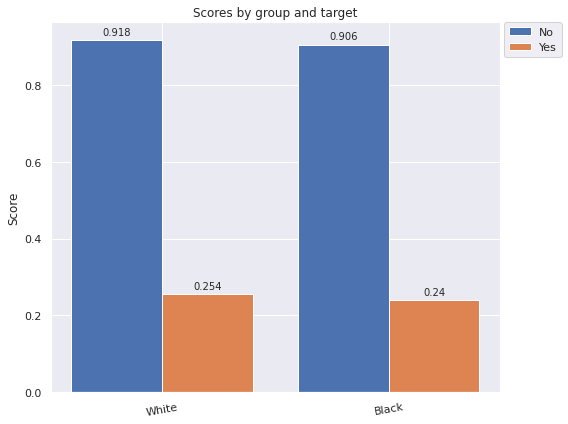

In [37]:
equalized_odds(y_pred_whitebox, val_race, val_target)

### Roc curve


In [82]:
pd.value_counts(y_pred_proba_whitebox[val_race=="Black"][:, 0])

1.000000    3027
0.000000     358
0.500000       8
0.666667       4
0.857143       1
0.833333       1
0.875000       1
0.750000       1
dtype: int64

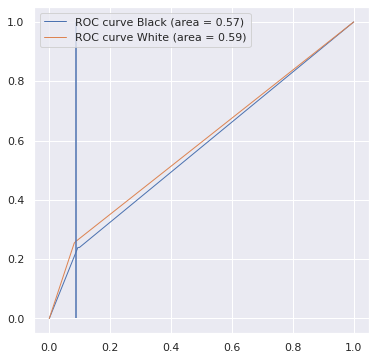

In [66]:
fix, ax = plt.subplots(figsize=(6,6))
parameters = {"fpr": [], "tpr": [], "threshold": []}

for race in np.unique(val_race):
    y_score = y_pred_proba_whitebox[val_race==race]
    fpr, tpr, threshold = roc_curve(val_target[val_race==race], y_score[:, 1], drop_intermediate=False)
    roc_auc = auc(fpr, tpr)
    
    ax.plot(
        fpr,
        tpr,
        lw=1,
        label=f"ROC curve {race} (area = %0.2f)" % roc_auc)
    parameters["fpr"].append(fpr)
    parameters["tpr"].append(tpr)
    parameters["threshold"].append(threshold)
    
plt.vlines(0.087, 0, 1) #example of desired fpr
plt.legend()

In [67]:
def find_thresholds(parameters, i, fpr_goal=0.087):
    threshold = parameters["threshold"][i]
    fpr = parameters["fpr"][i]
    
    idx = np.argmin(abs(fpr_goal - parameters["fpr"][i]))
    threshold = parameters["threshold"][i][idx]
    
    return threshold, idx

In [26]:
parameters["tpr"][0][idx_w]

0.8598326359832636

In [74]:
np.argmin(abs(0.087 - parameters["fpr"][0]))

1

In [83]:
races = ["White", "Black"]

white_threshold, idx_w = find_thresholds(parameters, 0)
black_threshold, idx_b = find_thresholds(parameters, 1)


print(white_threshold, black_threshold)

1.0 0.42857142857142855


In [84]:
# Re-calculate fairness metrics (equalized odds) with new thresholds
# this could be done with more races

y_pred_fair = list()
for race, proba in zip(val_original['Race'], y_pred_proba_whitebox[:,1]):
    if race == "White":
        y_pred_fair.append(1 if proba >= white_threshold else 0)
    elif race == "Black":
        y_pred_fair.append(1 if proba >= black_threshold else 0)
y_pred_fair = np.array(y_pred_fair)

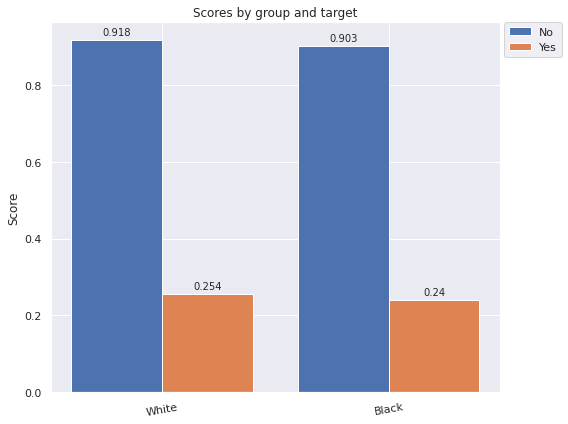

In [85]:
equalized_odds(y_pred_fair, val_race, val_target)

In [86]:
print(classification_report(val_target, y_pred_fair))
print(utils.classification_report(val_target, y_pred_fair, val_race))
print(confusion_matrix(val_target, y_pred_fair, normalize='true', labels=[1, 0]))

              precision    recall  f1-score   support

           0       0.93      0.92      0.92     36506
           1       0.23      0.25      0.24      3609

    accuracy                           0.86     40115
   macro avg       0.58      0.59      0.58     40115
weighted avg       0.86      0.86      0.86     40115

A                              TPR   FPR  
------------------------------------------
Black                          0.24  0.10 
White                          0.25  0.08 
All                            0.25  0.08 
[[0.25325575 0.74674425]
 [0.0832192  0.9167808 ]]


# Test set

In [87]:
y_pred_whitebox = whitebox_model.predict(test_processed)
y_pred_proba_whitebox = whitebox_model.predict_proba(test_processed)

In [88]:
print(classification_report(test_target, y_pred_whitebox))
print(utils.classification_report(test_target, y_pred_whitebox, test_race))
print(confusion_matrix(test_target, y_pred_whitebox, normalize='true', labels=[1, 0]))

              precision    recall  f1-score   support

           0       0.92      0.92      0.92     36590
           1       0.23      0.25      0.24      3643

    accuracy                           0.86     40233
   macro avg       0.58      0.58      0.58     40233
weighted avg       0.86      0.86      0.86     40233

A                              TPR   FPR  
------------------------------------------
Black                          0.26  0.08 
White                          0.25  0.08 
All                            0.25  0.08 
[[0.24732363 0.75267637]
 [0.08196228 0.91803772]]


In [89]:
y_pred_fair = list()
for race, proba in zip(test_original['Race'], y_pred_proba_whitebox[:,1]):
    if race == "White":
        y_pred_fair.append(1 if proba >= white_threshold else 0)
    elif race == "Black":
        y_pred_fair.append(1 if proba >= black_threshold else 0)
y_pred_fair = np.array(y_pred_fair)

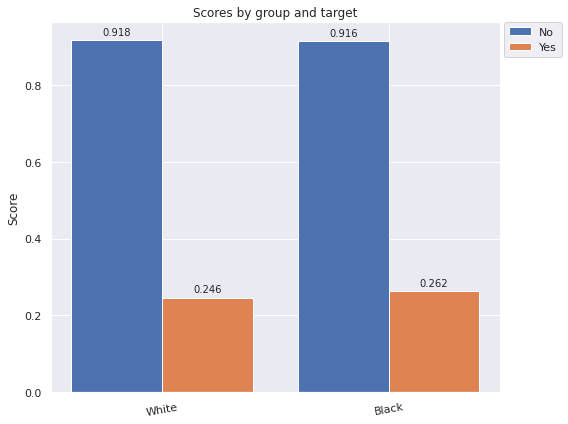

In [90]:
equalized_odds(y_pred_fair, test_race, test_target)

In [91]:
print(classification_report(test_target, y_pred_fair))
print(utils.classification_report(test_target, y_pred_fair, test_race))
print(confusion_matrix(test_target, y_pred_fair, normalize='true', labels=[1, 0]))

              precision    recall  f1-score   support

           0       0.92      0.92      0.92     36590
           1       0.23      0.25      0.24      3643

    accuracy                           0.86     40233
   macro avg       0.58      0.58      0.58     40233
weighted avg       0.86      0.86      0.86     40233

A                              TPR   FPR  
------------------------------------------
Black                          0.26  0.08 
White                          0.25  0.08 
All                            0.25  0.08 
[[0.24677464 0.75322536]
 [0.08204427 0.91795573]]


# Counterfactual Tests

In [266]:
# Example
counter_factual_test = pd.DataFrame(test_processed.iloc[0]).T
counter_factual_test

,BMI,PhysicalHealth,MentalHealth,SleepTime,AgeCategory,Race_White,Smoking_Yes,DiffWalking_Yes,GenHealth_Fair,GenHealth_Good,...,Asthma_Yes,Sex_Male,PhysicalActivity_Yes,AlcoholDrinking_Yes,KidneyDisease_Yes,SkinCancer_Yes,Stroke_Yes,"Diabetic_No, borderline diabetes",Diabetic_Yes,Diabetic_Yes (during pregnancy)
0,45.33,0.0,0.0,8.0,67.0,1.0,1.0,0.0,1.0,0.0,...,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


In [267]:
y_pred_proba_whitebox[0] #this is the models probability for 0 and 1 for this row ^

array([0.63161718, 0.36838282])

In [269]:
whitebox_model.predict_proba(counter_factual_test) == y_pred_proba_whitebox[0]

array([[ True,  True]])

In [270]:
# changing the DiffWalking_Yes
counter_factual_test["DiffWalking_Yes"] = 1.0

In [272]:
whitebox_model.predict_proba(counter_factual_test) #probability of heartdisease increases as expected

array([[0.5792354, 0.4207646]])

    Now trying to change the race

In [275]:
counter_factual_test["DiffWalking_Yes"] = 0 #changing it back for this experiment
counter_factual_test["Race_White"] = 0

In [277]:
proba = whitebox_model.predict_proba(counter_factual_test) #we see a less change of heartdisease
proba

array([[0.68773385, 0.31226615]])

In [280]:
1 if proba[:, 1] >= black_threshold else 0 #however, the check to ensure equalized odds does it thing

1

    Testing some edge cases near the probability thresholds

In [406]:
arr = y_pred_proba_whitebox

In [407]:
indexes = np.where(abs(arr-white_threshold) < 0.00001)[0] #0 is indexes of the array
indexes

array([10339, 13154, 24402, 30603])

In [408]:
df2 = test_processed.iloc[indexes].copy()
df2

,BMI,PhysicalHealth,MentalHealth,SleepTime,AgeCategory,Race_White,Smoking_Yes,DiffWalking_Yes,GenHealth_Fair,GenHealth_Good,GenHealth_Poor,GenHealth_Very good,Asthma_Yes,Sex_Male,PhysicalActivity_Yes,AlcoholDrinking_Yes,KidneyDisease_Yes,SkinCancer_Yes,Stroke_Yes,"Diabetic_No, borderline diabetes",Diabetic_Yes,Diabetic_Yes (during pregnancy)
12278,21.79,0.0,0.0,6.0,80.0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0
15607,32.28,0.0,0.0,8.0,72.0,1,0,0,0,0,0,1,1,0,1,0,0,0,0,1,0,0
29045,28.97,0.0,20.0,7.0,62.0,1,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
36494,27.12,0.0,0.0,8.0,67.0,1,0,0,0,0,0,1,0,1,1,0,0,0,0,0,0,0


In [409]:
test_target[indexes] #none of these have heartdisease!

array([0, 0, 0, 0])

In [410]:
proba = whitebox_model.predict_proba(df2) #model predicts just that
proba

array([[0.93375618, 0.06624382],
       [0.93375549, 0.06624451],
       [0.93374343, 0.06625657],
       [0.93375313, 0.06624687]])

In [411]:
white_threshold, black_threshold

(0.06624852769216266, 0.05431522517974116)

In [412]:
for prob in proba[:,1]:
    print(1 if prob >= white_threshold else 0) #the threshold predicts one of them to have heartdisease!

0
0
1
0


In [387]:
df2.at[36494, "GenHealth_Very good"] = 0 #changing last person's healthcondition

In [388]:
df2.at[36494, "GenHealth_Good"] = 1

In [389]:
df2

,BMI,PhysicalHealth,MentalHealth,SleepTime,AgeCategory,Race_White,Smoking_Yes,DiffWalking_Yes,GenHealth_Fair,GenHealth_Good,GenHealth_Poor,GenHealth_Very good,Asthma_Yes,Sex_Male,PhysicalActivity_Yes,AlcoholDrinking_Yes,KidneyDisease_Yes,SkinCancer_Yes,Stroke_Yes,"Diabetic_No, borderline diabetes",Diabetic_Yes,Diabetic_Yes (during pregnancy),GenHealth_VeryGood
12278,21.79,0.0,0.0,6.0,80.0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,NaN
15607,32.28,0.0,0.0,8.0,72.0,1,0,0,0,0,0,1,1,0,1,0,0,0,0,1,0,0,NaN
29045,28.97,0.0,20.0,7.0,62.0,1,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,NaN
36494,27.12,0.0,0.0,8.0,67.0,1,0,0,0,1,0,0,0,1,1,0,0,0,0,0,0,0,0.0


In [390]:
proba = whitebox_model.predict_proba(df2) #model predicts just that
proba

array([[0.93375618, 0.06624382],
       [0.93375549, 0.06624451],
       [0.93374343, 0.06625657],
       [0.88588372, 0.11411628]])

In [391]:
for prob in proba[:,1]:
    print(1 if prob >= white_threshold else 0) #the threshold predicts one of them to have heartdisease!

0
0
1
1


    Just above we see that changing a person's health from very good to good, means that our fair approach reports that thee person has heart disease! And by a lot in probability. Also, person with index 29045 has Good Health but his probability is a lot lower? 

In [393]:
pd.set_option('display.max_columns', None)

In [395]:
pd.DataFrame([df2.xs(29045), df2.xs(36494)]) #well, we notice that he is younger.

,BMI,PhysicalHealth,MentalHealth,SleepTime,AgeCategory,Race_White,Smoking_Yes,DiffWalking_Yes,GenHealth_Fair,GenHealth_Good,GenHealth_Poor,GenHealth_Very good,Asthma_Yes,Sex_Male,PhysicalActivity_Yes,AlcoholDrinking_Yes,KidneyDisease_Yes,SkinCancer_Yes,Stroke_Yes,"Diabetic_No, borderline diabetes",Diabetic_Yes,Diabetic_Yes (during pregnancy),GenHealth_VeryGood
29045,28.97,0.0,20.0,7.0,62.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN
36494,27.12,0.0,0.0,8.0,67.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


    changing race

In [413]:
df2 = test_processed.iloc[indexes].copy()
df2

,BMI,PhysicalHealth,MentalHealth,SleepTime,AgeCategory,Race_White,Smoking_Yes,DiffWalking_Yes,GenHealth_Fair,GenHealth_Good,GenHealth_Poor,GenHealth_Very good,Asthma_Yes,Sex_Male,PhysicalActivity_Yes,AlcoholDrinking_Yes,KidneyDisease_Yes,SkinCancer_Yes,Stroke_Yes,"Diabetic_No, borderline diabetes",Diabetic_Yes,Diabetic_Yes (during pregnancy)
12278,21.79,0.0,0.0,6.0,80.0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0
15607,32.28,0.0,0.0,8.0,72.0,1,0,0,0,0,0,1,1,0,1,0,0,0,0,1,0,0
29045,28.97,0.0,20.0,7.0,62.0,1,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
36494,27.12,0.0,0.0,8.0,67.0,1,0,0,0,0,0,1,0,1,1,0,0,0,0,0,0,0


In [414]:
proba = whitebox_model.predict_proba(df2)
proba

array([[0.93375618, 0.06624382],
       [0.93375549, 0.06624451],
       [0.93374343, 0.06625657],
       [0.93375313, 0.06624687]])

In [416]:
for prob in proba[:,1]:
    print(1 if prob >= white_threshold else 0)

0
0
1
0


In [417]:
df2.loc[:, "Race_White"] = 0

In [418]:
df2

,BMI,PhysicalHealth,MentalHealth,SleepTime,AgeCategory,Race_White,Smoking_Yes,DiffWalking_Yes,GenHealth_Fair,GenHealth_Good,GenHealth_Poor,GenHealth_Very good,Asthma_Yes,Sex_Male,PhysicalActivity_Yes,AlcoholDrinking_Yes,KidneyDisease_Yes,SkinCancer_Yes,Stroke_Yes,"Diabetic_No, borderline diabetes",Diabetic_Yes,Diabetic_Yes (during pregnancy)
12278,21.79,0.0,0.0,6.0,80.0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0
15607,32.28,0.0,0.0,8.0,72.0,0,0,0,0,0,0,1,1,0,1,0,0,0,0,1,0,0
29045,28.97,0.0,20.0,7.0,62.0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
36494,27.12,0.0,0.0,8.0,67.0,0,0,0,0,0,0,1,0,1,1,0,0,0,0,0,0,0


In [419]:
proba = whitebox_model.predict_proba(df2)
proba

array([[0.94766117, 0.05233883],
       [0.94766061, 0.05233939],
       [0.94765095, 0.05234905],
       [0.94765872, 0.05234128]])

In [421]:
for prob in proba[:,1]:
    print(1 if prob >= black_threshold else 0) #prediction is flipped to no heartdisease!

0
0
0
0


In [425]:
df2[:2]

,BMI,PhysicalHealth,MentalHealth,SleepTime,AgeCategory,Race_White,Smoking_Yes,DiffWalking_Yes,GenHealth_Fair,GenHealth_Good,GenHealth_Poor,GenHealth_Very good,Asthma_Yes,Sex_Male,PhysicalActivity_Yes,AlcoholDrinking_Yes,KidneyDisease_Yes,SkinCancer_Yes,Stroke_Yes,"Diabetic_No, borderline diabetes",Diabetic_Yes,Diabetic_Yes (during pregnancy)
12278,21.79,0.0,0.0,6.0,80.0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0
15607,32.28,0.0,0.0,8.0,72.0,0,0,0,0,0,0,1,1,0,1,0,0,0,0,1,0,0


In [446]:
race_weight = whitebox_model["clf"].coef_[0][4] #race

In [453]:
race_weight

0.9950316327354021

In [451]:
np.exp(race_weight*(0+1)-race_weight*0)

2.7048099004621036

    change in race, results in a change in the odds of healtdisease by 2.70 (i.e. exp(race_weight) -> exp(0.99))

In [455]:
np.exp(race_weight) == np.exp(race_weight*(0+1)-race_weight*0)

True